#Implements encoder/decoder for weak lensing outputs

The major idea is to see if I can compress the data in the snapshot files.
The result is that the compression of many different algorithms based on CNNs (of different depths) is not so much different than averaging neighboring cells (as shown at the end).  This in retrospect is not so surprising as there are differences on the cell scale in the maps that make compression challenging.

Set configurations for google COLAB if running there

In [1]:
import os


use_COLAB = 1 #1 is for on colab, and 2 is for on local machine but using colab

if use_COLAB >= 1:
  if use_COLAB == 2: # for running in VS CODE
      from colabcode import ColabCode
      ColabCode(port=10000)
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)

Mounted at /content/gdrive



## extract tarfiles if necessary and set specs for run



In [2]:

import tarfile
import os
import shutil
from astropy.io import fits
import numpy as np
from scipy.ndimage import zoom
import re
import tensorflow as tf
import random

#whether we are training or loading saved
train = True
load_saved = 1

#regularization parameters:
## generalization seems great on cosmological data and so generally I run with these off
L1weight = 0 #1e-8
dropout_rate = 0

# Specify the directory containing the .tar files
directory_path = './columbialensing/'

number_batches = 10
normalize_by_RMS = False #set to one if you want to renormalize by RMS

# image_size
image_size = 1024
sub_image_size = 64 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations



number_subimages_across =image_size//sub_image_size


number_fits_files = 512
suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"

#extracts only if indicated (could make this more elegant by checking to see if they exist)
if extract_tarfiles:
    # Use a regular expression to match .tar files with the desired suffix
    pattern = re.compile(rf"{suffix}.tar$")

    # List all matching .tar files in the directory
    all_tar_files = [f for f in os.listdir(directory_path) if pattern.search(f)]

    # Extract the tar archive
    for tar_file in all_tar_files:
        #print(tar_file)
        tar_file_path = os.path.join(directory_path, tar_file)
        with tarfile.open(tar_file_path, 'r') as archive:
            archive.extractall(path=directory_path)




# training schedule, import optimizer, and custom loss functions

I dont' necessarily use these, but used them to understand network optimization choices

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from keras import backend as K


#I was curious about how much of the loss owed to regularization, so this allows me to check at end of each batch (but was generating a warning in first batch)
class RegularizationLossMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        regularization_loss = sum(self.model.losses)
        total_loss = logs['loss']
        data_loss = total_loss - regularization_loss
        print(f'\n Regularization loss: {regularization_loss:.4f}',)
        print(f'Data loss: {data_loss:.4f}',)
        print(f'Total loss: {total_loss:.4f}')

#custom loss that compares fractional difference:  this metric makes sense
#because we want images that are close to each other everywhere.
#might not be ideal for optimization
def fractional_difference_loss(y_true, y_pred):
    epsilon = .01 # A small, non-zero number to prevent division by zero
    loss = K.mean(K.abs((y_pred - y_true) / (K.abs(y_true) + epsilon)), axis=-1)
    return loss

#custom loss that quare fo the fractional difference
def fractional_square_loss(y_true, y_pred):
    epsilon = 1e-2 # A small, non-zero number to prevent division by zero
    loss = K.square((y_pred - y_true) / (K.abs(y_true) + epsilon))
    return loss


reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5, min_lr=0.0001)

# Read into memory the data

In [4]:
#import wl_auxiliary

def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_fits_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float16)
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]/RMS

    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension

reading in Om0.268_si0.801
RMS=0.016497720032930374


# create decoder-encoder CNN with minimal number of layers, but final dense layer.  

  Here n sets the compression with the size compressed by the factor 4^n.  The result is n+1 layers, and most experiments I've run to test are n=2, or a compression by a factor of 16.

  The n CNN layers have number_channels channels, where I've experimented with 64 and 256

If load_saved= 1, it loads a trained version of this decoder-encoder




In [5]:
from tensorflow.keras import layers, models, regularizers
from keras.layers import LeakyReLU, BatchNormalization, Dropout

#Parameters for network
n=2 #number of layers (needs to be >2)
number_channels = 64

act_string = 'ReLU' #LeakyReLU(alpha=0.1) #okay, not a string

#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_d{dropout_rate }_logL1w{exponent}'

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

def create_simple_encoder(input_shape, n,  number_channels=number_channels, dropout_rate=dropout_rate):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels//2, (3, 3), activation=act_string, padding='same',\
              kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation=act_string, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    # Adding a Dense layer for encoding
    model.add(layers.Flatten())
    model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_string, \
              kernel_regularizer=regularizer))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))

    return model


def create_simple_decoder(encoded_length, original_shape, n, number_channels=number_channels, dropout_rate=dropout_rate):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer((encoded_length,)))



    # Expanding the flat array to a 3D tensor
    model.add(layers.Dense(units=np.prod(encoded_length*number_channels), activation=act_string,\
              kernel_regularizer=regularizer))

    # Calculate the dimensions for the first reshape
    # It should match the output size of the last MaxPooling layer in the encoder
    reshape_dims = (original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), number_channels)

    model.add(layers.Reshape(reshape_dims))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=act_string, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.UpSampling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=act_string, padding='same',\
                                     kernel_regularizer=regularizer))
    model.add(layers.UpSampling2D((2, 2)))
    if dropout_rate >0:
        model.add(Dropout(dropout_rate))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same',\
      kernel_regularizer=regularizer))

    return model



original_shape = [sub_image_size, sub_image_size, 1]


encoded_length = sub_image_size*sub_image_size//int(4**n)


model_name = f'simple_encoder_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    from tensorflow.keras.models import load_model
    print(f"loading saved model{model_name}")
    simple_encoder = load_model(model_name)
    simple_decoder = load_model(f'simple_decoder_{save_string}.keras')
else:
  if load_saved == 1 and not os.path.exists(model_name):
      print(f"Path does not exist to {model_name}.  Creating model")
  simple_encoder = create_simple_encoder(original_shape , n)
  simple_decoder = create_simple_decoder(encoded_length,original_shape, n)


# Combine the encoder and decoder to create the autoencoder
simple_autoencoder = models.Sequential([simple_encoder, simple_decoder])



loading saved modelsimple_encoder_n2_nc64_d0_logL1w+00.keras


In [ ]:
simple_encoder.summary() #summary of encoder
simple_decoder.summary() #summary of decoder

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                      

##Sets a learning rate scheduler, compiles the model, and trains

I've experimented with larger learning rates than 0.001, finding that five times this is too high as loss is very non-monatonic

In [6]:
if train:
  # Set the learning rate (I find that .005 is too large)
  learning_rate = 0.001

  simple_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae") #loss=fractional_difference_loss) #, run_eagerly=True)

  simple_autoencoder.fit(WL_tensor, WL_tensor, epochs=20, batch_size=256,
                shuffle=True, callbacks=[reduce_lr]) #, RegularizationLossMonitor()  If inlclude RegularizationLossMonitor() as a callback, separately prints regularization loss at the end of each batch
  simple_encoder.save(f'simple_encoder_{save_string}.keras')
  simple_decoder.save(f'simple_decoder_{save_string}.keras')

Epoch 1/20
512/512 [==============================] - 37s 48ms/step - loss: 0.2337 - lr: 0.0010
Epoch 2/20
512/512 [==============================] - 25s 49ms/step - loss: 0.2285 - lr: 0.0010
Epoch 3/20
512/512 [==============================] - 25s 50ms/step - loss: 0.2283 - lr: 0.0010
Epoch 4/20
512/512 [==============================] - 26s 51ms/step - loss: 0.2280 - lr: 0.0010
Epoch 5/20
166/512 [========>.....................] - ETA: 17s - loss: 0.2281

KeyboardInterrupt: ignored

# Encoder-decoder 2:  

This takes out the dense layers and replaces it with 1x1 convolution layer.  This makes a pure CNN encoder-decoder and the output now is in terms of pixels and channels rather than one vector.  This felt more physically motivated.  Now n=4 and 16 channels is the same compression as n=2 previously.

In [7]:
from tensorflow.keras import layers, models, regularizers
from keras.layers import LeakyReLU, BatchNormalization, Dropout

#Parameters for network
n=4 #number of layers (needs to be >2)
number_channels = 256 #these are intermediate  channels
number_final_channels = 16  # if n=4 and number_final_channels = 16, this is eqivalent to n=2 decompression in other encoders

act_string = 'ReLU' #LeakyReLU(alpha=0.1) #okay, not a string

#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_nfc{number_final_channels}_d{dropout_rate }_logL1w{exponent}'

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

def create_CNN_encoder(input_shape, n,  number_channels=number_channels, dropout_rate=dropout_rate):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels//2, (3, 3), activation=None, padding='same',\
              kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation=None, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Activation(act_string))
        model.add(layers.MaxPooling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    # Adding a Dense layer for encoding

    model.add(layers.Conv2D(number_final_channels, (1, 1), activation=None, padding='same',\
          kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))
    if dropout_rate >0:
        model.add(Dropout(dropout_rate))


    #model.add(layers.Flatten())
    #model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_string, \
    #          kernel_regularizer=regularizer))

    return model


def create_CNN_decoder(original_shape, n, number_channels=number_channels, dropout_rate=dropout_rate):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer( (original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), number_final_channels)))

    model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation=None, padding='same',\
                  kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=None, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Activation(act_string))
        model.add(layers.UpSampling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=None, padding='same',\
                                     kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))

    model.add(layers.UpSampling2D((2, 2)))
    if dropout_rate >0:
        model.add(Dropout(dropout_rate))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same',\
      kernel_regularizer=regularizer))

    return model



original_shape = [sub_image_size, sub_image_size, 1]


model_name = f'CNN_encoder_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    from tensorflow.keras.models import load_model
    print(f"loading saved model{model_name}")
    CNN_encoder = load_model(model_name)
    CNN_decoder = load_model(f'CNN_decoder_{save_string}.keras')
else:
  if load_saved == 1 and not os.path.exists(model_name):
      print(f"Path does not exist to {model_name}.  Creating model")
  CNN_encoder = create_CNN_encoder(original_shape, n)
  CNN_decoder = create_CNN_decoder(original_shape, n)


# Combine the encoder and decoder to create the autoencoder
CNN_autoencoder = models.Sequential([CNN_encoder, CNN_decoder])

CNN_encoder.summary()
CNN_decoder.summary()


loading saved modelCNN_encoder_n4_nc256_nfc16_d0_logL1w+00.keras
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 64, 64, 128)       1280      
                                                                 
 batch_normalization_22 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 64, 64, 128)       0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 256)       295168    
                                                      

In [ ]:
if train:

  learning_rate = .001

  CNN_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae")
  CNN_autoencoder.fit(WL_tensor, WL_tensor, epochs=20, batch_size=256,
                shuffle=True, callbacks=[reduce_lr]) #, RegularizationLossMonitor()  If inlclude RegularizationLossMonitor() as a callback, separately prints regularization loss at the end of each batch
  CNN_encoder.save(f'CNN_encoder_{save_string}.keras')
  CNN_decoder.save(f'CNN_decoder_{save_string}.keras')

Epoch 1/20
512/512 [==============================] - 164s 310ms/step - loss: 0.3946 - lr: 0.0010
Epoch 2/20
512/512 [==============================] - 166s 324ms/step - loss: 0.3122 - lr: 0.0010
Epoch 3/20
360/512 [====================>.........] - ETA: 49s - loss: 0.2891

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-defc2d82a614>", line 6, in <cell line: 1>
    CNN_autoencoder.fit(WL_tensor, WL_tensor, epochs=20, batch_size=256,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1789, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 475, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, "end", batch, logs=logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 322, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "/usr/local/lib/python3.10/dist-packages/kera

#Encoder Decoder 3 (residual connections)

This now is the same CNN as our first but with residual connections

In [8]:
from tensorflow.keras import layers, models, regularizers
from keras.layers import LeakyReLU, BatchNormalization, Dropout

n=2
number_channels = 64

act_string = 'ReLU'# LeakyReLU(alpha=0.1) #okay, not a string



# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None


#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_d{dropout_rate }_logL1w{exponent}'


def create_encoder_residconnect(input_shape, n, number_channels=number_channels, act_string=act_string, dropout_rate=0, regularizer=regularizer):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Initial Convolutional Layer
    x = layers.Conv2D(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_string)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    # Additional Layers with Residual Connections
    for _ in range(1, n):
        identity = x
        x = layers.Conv2D(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act_string)(x)
        x = layers.Conv2D(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([x, identity])  # Residual Connection
        x = layers.Activation(act_string)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)

    # Flatten and Dense Layer
    x = layers.Flatten()(x)
    x = layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_string, kernel_regularizer=regularizer)(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    model = models.Model(inputs, x)
    return model

def create_decoder_residconnect(encoded_length, original_shape, n, number_channels=number_channels, act_string=act_string, dropout_rate=0, regularizer=regularizer):
    inputs = layers.Input(shape=(encoded_length,))
    x = inputs

    # Dense layer
    x = layers.Dense(units=np.prod(encoded_length*number_channels), activation=act_string, kernel_regularizer=regularizer)(x)
    x = layers.Reshape((original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), number_channels))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_string)(x)

    # Upsampling Layers with Residual Connections
    for _ in range(1, n):
        identity = x
        x = layers.Conv2DTranspose(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act_string)(x)
        x = layers.Conv2DTranspose(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([x, identity])  # Residual Connection
        x = layers.Activation(act_string)(x)
        x = layers.UpSampling2D((2, 2))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)

    # Final Conv2DTranspose to get back to original shape
    x = layers.Conv2DTranspose(number_channels, (3, 3), activation=act_string, padding='same', kernel_regularizer=regularizer)(x)
    x = layers.UpSampling2D((2, 2))(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same', kernel_regularizer=regularizer)(x)

    model = models.Model(inputs, x)
    return model



n=2 #number of layers (needs to be >2)
original_shape = [sub_image_size, sub_image_size, 1]
encoded_length = sub_image_size*sub_image_size//int(4**n)

model_name = f'encoder_residconnect_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    from tensorflow.keras.models import load_model
    print(f"loading saved model{model_name}")
    encoder_residconnect= load_model(f'encoder_residconnect_{save_string}.keras')
    decoder_residconnect = load_model(f'decoder_residconnect_{save_string}.keras')

else:
  if load_saved == 1 and not os.path.exists(model_name):
        print(f"Path does not exist to {model_name}.  Creating model")
  encoder_residconnect = create_encoder_residconnect(original_shape , n)
  decoder_residconnect = create_decoder_residconnect(encoded_length,original_shape, n)

# Combine the encoder and decoder to create the autoencoder
autoencoder_residconnect = models.Sequential([encoder_residconnect, decoder_residconnect])

encoder_residconnect.summary()
decoder_residconnect.summary()

loading saved modelencoder_residconnect_n2_nc64_d0_logL1w+00.keras
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 64, 64, 64)           640       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 64, 64, 64)           256       ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_6 (Activation

In [ ]:
if train:
  # Set the learning rate
  learning_rate = 0.001

  autoencoder_residconnect.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae")

  autoencoder_residconnect.fit(WL_tensor, WL_tensor, epochs=20,batch_size=256,
                shuffle=True, callbacks=[reduce_lr]) #, RegularizationLossMonitor()
  encoder_residconnect.save(f'encoder_residconnect_{save_string}.keras')
  decoder_residconnect.save(f'decoder_residconnect_{save_string}.keras')

Epoch 1/20
512/512 [==============================] - 64s 119ms/step - loss: 0.4602 - lr: 0.0010
Epoch 2/20
512/512 [==============================] - 60s 117ms/step - loss: 0.3051 - lr: 0.0010
Epoch 3/20
512/512 [==============================] - 60s 117ms/step - loss: 0.2714 - lr: 0.0010
Epoch 4/20
512/512 [==============================] - 60s 117ms/step - loss: 0.2558 - lr: 0.0010
Epoch 5/20
512/512 [==============================] - 60s 117ms/step - loss: 0.2472 - lr: 0.0010
Epoch 6/20
512/512 [==============================] - 60s 117ms/step - loss: 0.2419 - lr: 0.0010
Epoch 7/20
512/512 [==============================] - 60s 118ms/step - loss: 0.2384 - lr: 0.0010
Epoch 8/20
512/512 [==============================] - 60s 118ms/step - loss: 0.2360 - lr: 0.0010
Epoch 9/20
512/512 [==============================] - 60s 118ms/step - loss: 0.2329 - lr: 0.0010
Epoch 10/20
512/512 [==============================] - 60s 118ms/step - loss: 0.2306 - lr: 0.0010
Epoch 11/20
512/512 [========

## Encoder-decoder 4: most complex model, and removing pooling

I've added 2*(n-1) additional layers, half 1x1 convolutions and half 3x3.

In [9]:
from tensorflow.keras import layers, models, regularizers
from keras.layers import LeakyReLU, BatchNormalization, Dropout

n=2
number_channels = 32
number_dense = 1

act_func = 'ReLU' #LeakyReLU(alpha=0.1)


# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None


#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_d{dropout_rate }_logL1w{exponent}'
if number_dense > 1:
  save_string = save_string + f'_nd{number_dense}'

def create_encoder(input_shape, n, number_channels=64, act_string=act_func, regularizer=regularizer):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels//2, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.Conv2D(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
    #model.add(layers.MaxPooling2D((2, 2)))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels//2**nlayer, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Conv2D(number_channels//2**nlayer, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2D(number_channels//2**nlayer, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        #model.add(layers.MaxPooling2D((2, 2)))

    # Adding a Dense layer for encoding
    model.add(layers.Flatten())
    for i in range(number_dense):
      model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_func, kernel_regularizer=regularizer))

    return model


def create_decoder(encoded_length, original_shape, n, number_channels=number_channels, act_string=act_func, regularizer=regularizer):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer((encoded_length,)))



    # Expanding the flat array to a 3D tensor
    for i in range(number_dense):
      model.add(layers.Dense(units=np.prod(original_shape[0]*original_shape[1] *number_channels//2**n), activation=act_func, kernel_regularizer=regularizer))


    # Calculate the dimensions for the first reshape
    # It should match the output size of the last MaxPooling layer in the encoder
    reshape_dims = (original_shape[0], original_shape[1] , number_channels//2**n)

    model.add(layers.Reshape(reshape_dims))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels//2**(n-nlayer+1), (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Conv2DTranspose(number_channels//2**(n-nlayer+1), (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2DTranspose(number_channels//2**(n-nlayer+1), (3, 3), activation=act_func, padding='same'))
        model.add(BatchNormalization())
        #model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
    #model.add(layers.UpSampling2D((2, 2)))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same', kernel_regularizer=regularizer))

    return model





n=2 #number of layers (needs to be >2)
original_shape = [sub_image_size, sub_image_size, 1]


encoded_length = sub_image_size*sub_image_size//int(4**n)

#load_saved = 0
model_name = f'encoder_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    print(f"loading saved model{model_name}")
    encoder= load_model(f'encoder_{save_string}.keras')
    decoder = load_model(f'decoder_{save_string}.keras')
else:
    if load_saved == 1 and not os.path.exists(model_name):
        print(f"Path does not exist to {model_name}.  Creating model...")
    # Combine the encoder and decoder to create the autoencoder
    encoder = create_encoder(original_shape , n)
    decoder = create_decoder(encoded_length,original_shape, n)

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()


Path does not exist to encoder_n2_nc32_d0_logL1w+00.keras.  Creating model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        2112      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        1056      
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64

# compile and train complex CNN

In [10]:
if train:
  # Set the learning rate
  learning_rate = 0.001
  autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae") #loss=fractional_difference_loss) #, run_eagerly=True)
  autoencoder.fit(WL_tensor, WL_tensor, epochs=2, batch_size=256,
                shuffle=True, callbacks=[reduce_lr])
  encoder.save(f'encoder_{save_string}.keras')
  decoder.save(f'decoder_{save_string}.keras')

Epoch 1/2
512/512 [==============================] - 101s 181ms/step - loss: 0.3307 - lr: 0.0010
Epoch 2/2
512/512 [==============================] - 93s 182ms/step - loss: 0.2238 - lr: 0.0010



# Switching our most complex to layer normalization





In [12]:

from tensorflow.keras import layers, models, regularizers
from keras.layers import LayerNormalization, Dropout



n=2
number_channels = 64
number_dense = 2

act_func = 'ReLU'


# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None


#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_d{dropout_rate }_logL1w{exponent}'
if number_dense > 1:
  save_string = save_string + f'_nd{number_dense}'

def motivated_create_encoder(input_shape, n, number_channels=64, act_string=act_string, regularizer=regularizer):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels//2, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.Conv2D(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.AveragePooling2D((2, 2)))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(LayerNormalization())
        model.add(layers.Conv2D(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2D(number_channels, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(LayerNormalization())
        model.add(layers.AveragePooling2D((2, 2)))

    # Adding a Dense layer for encoding
    model.add(layers.Flatten())
    for i in range(number_dense):
      model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_func, kernel_regularizer=regularizer))
      model.add(LayerNormalization())

    return model


def motivated_create_decoder(encoded_length, original_shape, n, number_channels=64, act_string=act_string, regularizer=regularizer):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer((encoded_length,)))



    # Expanding the flat array to a 3D tensor
    for i in range(number_dense-1):
      model.add(layers.Dense(units=np.prod(encoded_length*64), activation=act_func, kernel_regularizer=regularizer))
      model.add(LayerNormalization())

    # Calculate the dimensions for the first reshape
    # It should match the output size of the last MaxPooling layer in the encoder
    reshape_dims = (original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), 64)

    model.add(layers.Reshape(reshape_dims))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n-1):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(LayerNormalization())
        model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=act_func, padding='same'))
        model.add(LayerNormalization())
        model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.UpSampling2D((2, 2)))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same', kernel_regularizer=regularizer))

    return model





n=2 #number of layers (needs to be >2)
original_shape = [sub_image_size, sub_image_size, 1]


encoded_length = sub_image_size*sub_image_size//int(4**n)

#load_saved = 1
model_name = f'motivated_encoder_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    print(f"loading saved model{model_name}")
    motivated_encoder= load_model(f'encoder_{save_string}.keras')
    motivated_decoder = load_model(f'decoder_{save_string}.keras')
else:
    if load_saved == 1 and not os.path.exists(model_name):
        print(f"Path does not exist to {model_name}.  Creating model...")
    # Combine the encoder and decoder to create the autoencoder
    motivated_encoder = motivated_create_encoder(original_shape , n)
    motivated_decoder = motivated_create_decoder(encoded_length,original_shape, n)

motivated_autoencoder = models.Sequential([motivated_encoder, motivated_decoder])

motivated_encoder.summary()
motivated_decoder.summary()


Path does not exist to motivated_encoder_n2_nc64_d0_logL1w+00_nd2.keras.  Creating model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        2112      
                                                                 
 average_pooling2d (Average  (None, 32, 32, 64)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 layer_normalization (Layer  (None, 32, 32, 64)        128       
 Normalization)                                                  
                            

In [13]:
if train:
  # Set the learning rate
  learning_rate = 0.001
  motivated_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae") #loss=fractional_difference_loss) #, run_eagerly=True)
  motivated_autoencoder.fit(WL_tensor, WL_tensor, epochs=20, batch_size=256,
                shuffle=True, callbacks=[reduce_lr])
  motivated_encoder.save(f'encoder_{save_string}.keras')
  motivated_decoder.save(f'decoder_{save_string}.keras')

Epoch 1/20


ValueError: ignored

#This shows images from the various encoders/decoders

change number_dcoders to compare more decoders, if they are loaded


-2
MAE loss for averaged map =  0.2817
MAE loss for decoder 0 =  0.2607
MAE loss for decoder 1 =  0.2996
MAE loss for decoder 2 =  0.258
MAE loss for decoder 3 =  0.3098


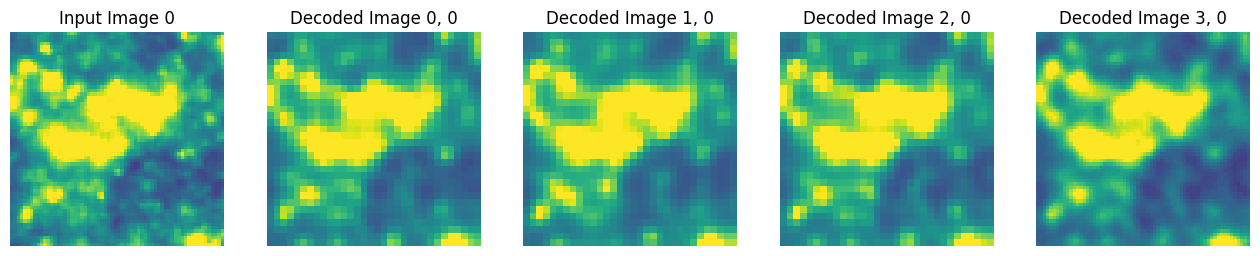

MAE loss for averaged map =  0.339
MAE loss for decoder 0 =  0.3027
MAE loss for decoder 1 =  0.364
MAE loss for decoder 2 =  0.2979
MAE loss for decoder 3 =  0.424


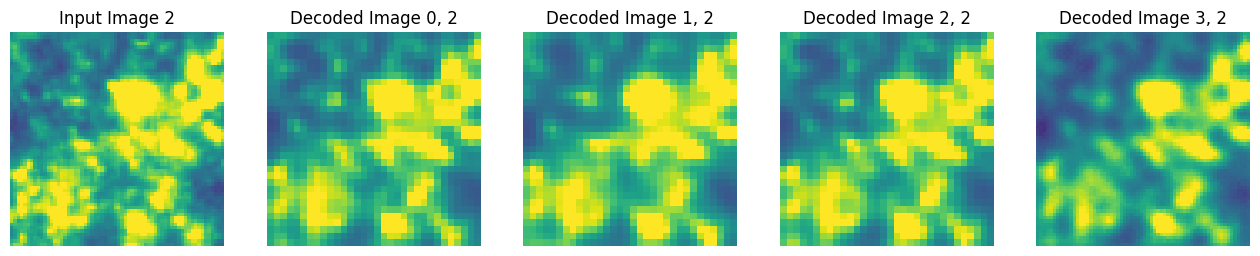

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

# Assuming WL_tensor is a 4D tensor with shape (num_images, height, width, channels)
# and sub_image_size is the size of the second and third dimensions (height and width).
num_images = 5
sub_image_size = WL_tensor.shape[1]  # Assuming height and width are the same

[vmin, vmax]=[-3, 3];
[vmin2, vmax2]=[-3, 3];

print(vmin2)

show_difference = False
make_last_image_zoom = True
number_decoders = 4

decoded_images = [None]*num_images

# Get the outputs from the decoder
decoded_images[0] = simple_decoder(simple_encoder(WL_tensor[:num_images,...])).numpy()

if number_decoders >= 2:
  decoded_images[1] = CNN_decoder(CNN_encoder(WL_tensor[:num_images,...])).numpy()
if number_decoders >=3:
    decoded_images[2] = decoder_residconnect(encoder_residconnect(WL_tensor[:num_images,...])).numpy()
if number_decoders >=4:
    #decoded_images[3] = zoom(WL_tensor[index, :, :, 0], 0.25)
    decoded_images[3] = decoder(encoder(WL_tensor[:num_images,...])).numpy()

# Function to display images
def display_side_by_side(index):
    if index < 0 or index >= num_images:
        raise ValueError("Index out of bounds")

    # Select the specific input and output images
    input_image = WL_tensor[index, :, :, 0]  # Assuming grayscale, channel dimension is 0

    if make_last_image_zoom:
      decoded_images[-1] = zoom(np.array(input_image).astype(np.float32), 0.25)
      decoded_images_comparison = np.array(zoom(decoded_images[-1], 4)).astype(np.float16)
      print("MAE loss for averaged map = ", np.mean(np.abs(input_image -decoded_images_comparison)))

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, number_decoders+1, figsize=(4*number_decoders, 10))

    # Display the input image in the first subplot
    axes[0].imshow(input_image, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Input Image {index}')
    axes[0].axis('off')  # Hide the axis

    # Display the output image in the second subplot
    for i in range(number_decoders):
        output_image = decoded_images[i][index, :, :, 0]

        print(f"MAE loss for decoder {i} = ", np.mean(np.abs(input_image -output_image )))
        if show_difference:
          vmin2 = -.02; vmax2=0.02
          output_image = output_image - input_image
        axes[i+1].imshow(output_image, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[i+1].set_title(f'Decoded Image {i}, {index}')
        axes[i+1].axis('off')  # Hide the axis

    # Display the images
    plt.show()


# Example usage for the first image
display_side_by_side(0)  # You can loop or call this function for other indices as well
display_side_by_side(2)